In [1]:
import numpy as np
import jax.numpy as jnp

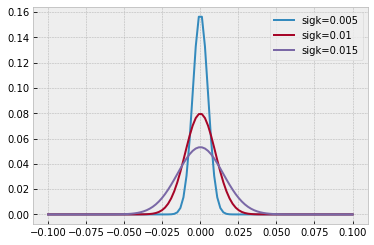

In [103]:
Nk=100
xk=np.linspace(-0.1,0.1,Nk)
def kernel(sigk):
    k=np.exp(-xk**2/(2.*sigk**2))/np.sqrt(2.*np.pi)/sigk*(0.2/Nk)
    return k

plt.plot(xk,kernel(0.005),label="sigk=0.005")
plt.plot(xk,kernel(0.01),label="sigk=0.01")
plt.plot(xk,kernel(0.015),label="sigk=0.015")
plt.legend()
plt.savefig("kernel.pdf")

In [89]:
np.random.seed(32)
sigk=0.01
sigin=0.3

xk=np.linspace(-0.1,0.1,100)
def kernel(sigk):
    k=np.exp(-xk**2/(2.*sigk**2))/np.sqrt(2.*np.pi)/sigk*(0.2/Nk)
    return k

N=1000
x=np.linspace(-1,1,N)
yp=np.zeros(N)
yp[300]=100.0;yp[700]=100.0;yp[500]=200.0
y=np.convolve(yp,kernel(sigk),"same")+np.random.normal(0,sigin,size=N)

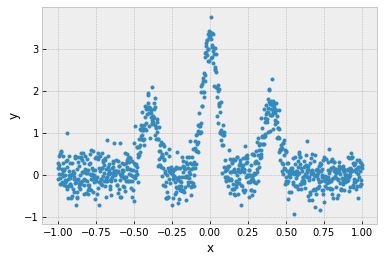

In [92]:
import matplotlib.pyplot as plt
plt.plot(x,y,".",color="C0")
#plt.plot(x,yp,".",color="C1")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
#plt.savefig("hmc1.pdf")

In [110]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist


def model(x,y):
    sigk = numpyro.sample('sigk', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    mu=jnp.convolve(yp,jnp.exp(-xkx**2/(2.*sigk**2)) \
                   /jnp.sqrt(2.*jnp.pi)/sigk*(0.2/Nk),"same")
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [111]:
from jax import random
from numpyro.infer import MCMC, NUTS

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, x=x, y=y)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:11<00:00, 268.92it/s, 3 steps of size 8.83e-01. acc. prob=0.92]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      sigk      0.05      0.00      0.05      0.05      0.05   1717.93      1.00
     sigma      0.30      0.01      0.29      0.29      0.31   1271.18      1.00

Number of divergences: 0


In [95]:
samples = mcmc.get_samples()
samples["sigk"]

DeviceArray([0.04950225, 0.04913771, 0.04926179, ..., 0.04973058,
             0.04923527, 0.04879174], dtype=float32)

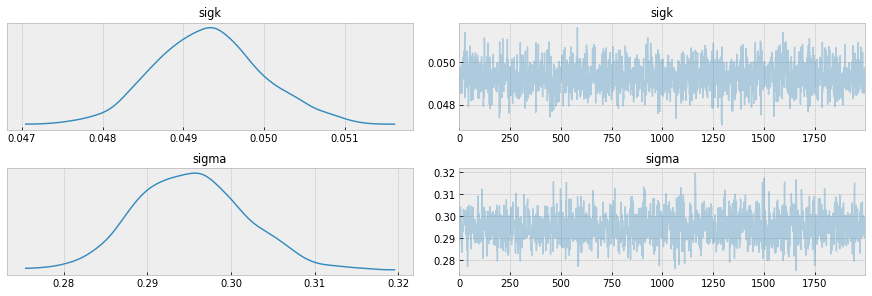

In [96]:
import arviz
arviz.plot_trace(mcmc, var_names=["sigk","sigma"])
plt.savefig("hmc2.pdf")

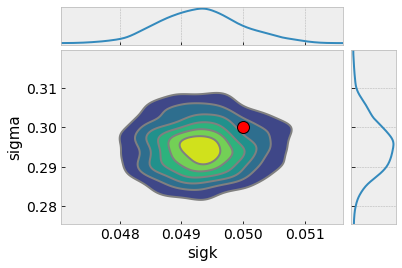

In [97]:
refs={};refs["sigma"]=sigin;refs["sigk"]=sigk
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',
    divergences=False,marginals=True,reference_values=refs,
    reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.savefig("hmc3.pdf", bbox_inches="tight", pad_inches=0.0)

In [98]:
posterior_sigk = mcmc.get_samples()['sigk']
posterior_sigma = mcmc.get_samples()['sigma']

In [99]:
from numpyro.infer import Predictive
pred = Predictive(model,{'sigk':posterior_sigk,'sigma':posterior_sigma},return_sites=["y"])
x_ = jnp.linspace(-1,1,N)
predictions = pred(rng_key_,x=x_,y=None)

In [100]:
from numpyro.diagnostics import hpdi
mean_muy = jnp.mean(predictions["y"], axis=0)
hpdi_muy = hpdi(predictions["y"], 0.9)

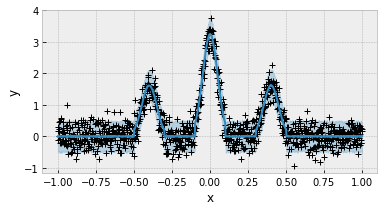

In [101]:
import seaborn as sns
plt.style.use('bmh')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(x,y,"+",color="black")
ax.plot(x_,mean_muy,color="C0")
ax.fill_between(x_, hpdi_muy[0], hpdi_muy[1], alpha=0.3, interpolate=True,color="C0")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("hmc4.pdf")